# Logistic Regression Classifier

The goal of this notebook is to classify our samples using a Logistic Regression model. We will attempt 3 different variations in terms of target variables.

1. Each individual accent
2. Consolidated accents (North, Mid, South, West)
3. Further consolidated regions (East, west)




In [4]:
import librosa
import os
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, pairwise_distances, confusion_matrix

from matplotlib.colors import ListedColormap

from sklearn.linear_model import LogisticRegression

In [22]:
accent_map = {
    'DR1':'New England',
    'DR2':'Northern',
    'DR3': 'North Midland',
    'DR4': 'South Midland',
    'DR5': 'Southern', 
    'DR6': 'New York City',
    'DR7': 'Western',
    'DR8': 'Moved Around'
}

In [5]:
def plot_conf_matconf(conf_mat, save_fig=None):
    fig = plt.figure(figsize=(16, 14))
    ax= plt.subplot()
    sns.heatmap(conf_mat, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells

    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True', fontsize=20)
    plt.yticks(rotation=0)

    plt.title('Refined Confusion Matrix', fontsize=20)

    if save_fig:
        plt.savefig(f'{save_fig}.png')

    plt.show()

In [33]:
def average_speakers(mfcc_df):
    
    feature_cols = [x for x in mfcc_df.columns if x in ('f1', 'f2', 'f3', 'f4', 'f5', 'bw1', 'bw2', 'bw3', 'bw4', 'bw5')]
    
    target = mfcc_df[['speaker', 'accent']].drop_duplicates()
    
    mfcc_grouped = mfcc_df.groupby(['speaker', 'phoneme'])[feature_cols].mean().reset_index()
    
    joined = pd.merge(how='left', left=mfcc_grouped, right = target, left_on='speaker', right_on = 'speaker')
    
    return joined, feature_cols




def load_data():
    train = pd.read_csv('../../../data/train_formants_phonemes.csv')
    test = pd.read_csv('../../../data/test_formants_phonemes.csv')
    
    train = train.loc[train['accent'] != 'DR8']
    test = test.loc[test['accent'] != 'DR8']
    test = test.loc[test.word.isin(train.word)].reset_index()
    
    train, feature_cols = average_speakers(train)
    
    british_df = pd.read_csv('../../../data/british_formants_phonemes.csv')
    feature_cols = [x for x in british_df.columns if x in ('f1', 'f2', 'f3', 'f4', 'f5', 'bw1', 'bw2', 'bw3', 'bw4', 'bw5')]
    
    return train, test, british_df[feature_cols], feature_cols


train, test, british_df, feature_cols = load_data()

In [34]:
train.head()

,speaker,phoneme,f1,f2,f3,f4,f5,bw1,bw2,bw3,bw4,bw5,accent
0,FAEM0,aa,860.936508,1484.132472,3320.940160,4168.831984,7265.505712,860.936508,1484.132472,3320.940160,4168.831984,7265.505712,DR2
1,FAEM0,ae,720.479657,2206.246550,3104.918833,4252.660636,7091.878219,720.479657,2206.246550,3104.918833,4252.660636,7091.878219,DR2
2,FAEM0,ah,801.809228,1536.928458,3500.230589,4478.219205,7226.945265,801.809228,1536.928458,3500.230589,4478.219205,7226.945265,DR2
3,FAEM0,ao,802.731525,1654.042603,3621.243620,5809.490637,7186.334006,802.731525,1654.042603,3621.243620,5809.490637,7186.334006,DR2
4,FAEM0,aw,812.146971,1883.097469,3543.506370,4139.882569,7456.033400,812.146971,1883.097469,3543.506370,4139.882569,7456.033400,DR2


In [35]:
train.head()

,speaker,phoneme,f1,f2,f3,f4,f5,bw1,bw2,bw3,bw4,bw5,accent
0,FAEM0,aa,860.936508,1484.132472,3320.940160,4168.831984,7265.505712,860.936508,1484.132472,3320.940160,4168.831984,7265.505712,DR2
1,FAEM0,ae,720.479657,2206.246550,3104.918833,4252.660636,7091.878219,720.479657,2206.246550,3104.918833,4252.660636,7091.878219,DR2
2,FAEM0,ah,801.809228,1536.928458,3500.230589,4478.219205,7226.945265,801.809228,1536.928458,3500.230589,4478.219205,7226.945265,DR2
3,FAEM0,ao,802.731525,1654.042603,3621.243620,5809.490637,7186.334006,802.731525,1654.042603,3621.243620,5809.490637,7186.334006,DR2
4,FAEM0,aw,812.146971,1883.097469,3543.506370,4139.882569,7456.033400,812.146971,1883.097469,3543.506370,4139.882569,7456.033400,DR2


In [36]:
test.shape # 13596

test.loc[test['phoneme'].isin(train['phoneme'])].shape

(42195, 44)

In [37]:
test.accent.value_counts()

DR4    12207
DR5     6510
DR3     6426
DR2     6265
DR7     5445
DR1     2691
DR6     2651
Name: accent, dtype: int64

In [41]:
train.head()

,speaker,phoneme,f1,f2,f3,f4,f5,bw1,bw2,bw3,bw4,bw5,accent
0,FAEM0,aa,860.936508,1484.132472,3320.940160,4168.831984,7265.505712,860.936508,1484.132472,3320.940160,4168.831984,7265.505712,DR2
1,FAEM0,ae,720.479657,2206.246550,3104.918833,4252.660636,7091.878219,720.479657,2206.246550,3104.918833,4252.660636,7091.878219,DR2
2,FAEM0,ah,801.809228,1536.928458,3500.230589,4478.219205,7226.945265,801.809228,1536.928458,3500.230589,4478.219205,7226.945265,DR2
3,FAEM0,ao,802.731525,1654.042603,3621.243620,5809.490637,7186.334006,802.731525,1654.042603,3621.243620,5809.490637,7186.334006,DR2
4,FAEM0,aw,812.146971,1883.097469,3543.506370,4139.882569,7456.033400,812.146971,1883.097469,3543.506370,4139.882569,7456.033400,DR2


In [51]:
feature_cols = [x for x in train.columns if x in ('f1', 'f2', 'f3', 'f4', 'f5', 'bw1', 'bw2', 'bw3', 'bw4', 'bw5')]

train[feature_cols] = train[feature_cols].fillna(value=train[feature_cols].mean())
test[feature_cols] = test[feature_cols].fillna(value=train[feature_cols].mean())
british_df[feature_cols] = british_df[feature_cols].fillna(value=train[feature_cols].mean())

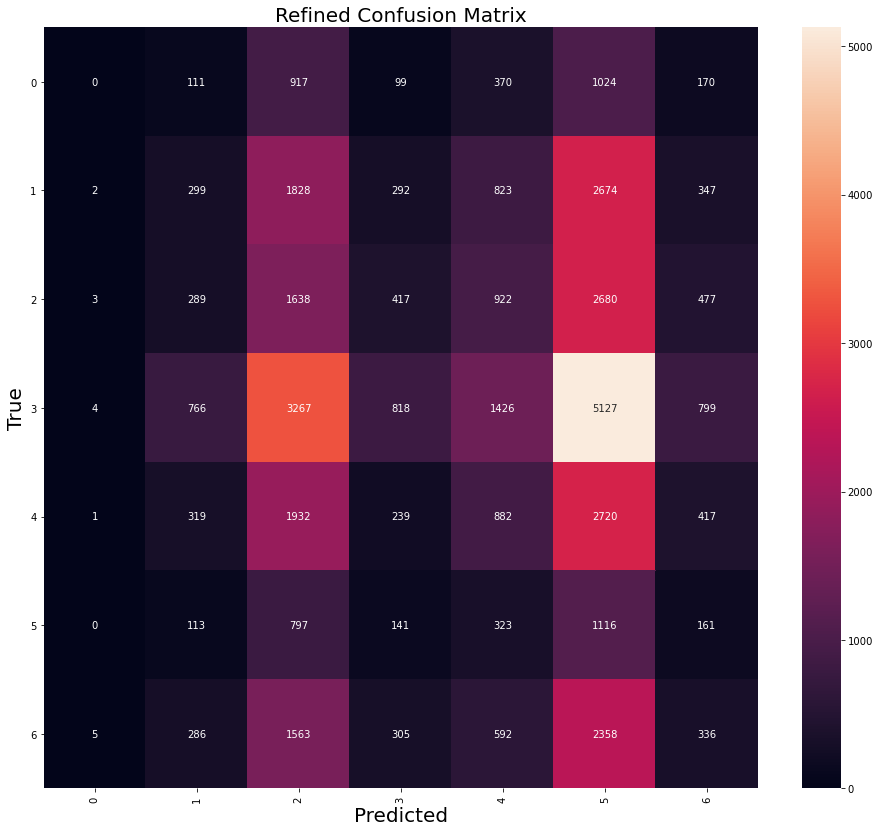

Logistic Reg Number of mislabeled points out of a total 42195 points : 37106
              DR1          DR2          DR3           DR4          DR5  \
precision     0.0     0.136967     0.137163      0.353959     0.165230   
recall        0.0     0.047725     0.254902      0.067011     0.135484   
f1-score      0.0     0.070786     0.178354      0.112688     0.148886   
support    2691.0  6265.000000  6426.000000  12207.000000  6510.000000   

                   DR6          DR7  accuracy     macro avg  weighted avg  
precision     0.063054     0.124123  0.120607      0.140071      0.189097  
recall        0.420973     0.061708  0.120607      0.141115      0.120607  
f1-score      0.109681     0.082434  0.120607      0.100404      0.110772  
support    2651.000000  5445.000000  0.120607  42195.000000  42195.000000  


In [49]:
def logistic_reg(train, test, display_conf=True, word=None, features = None):
    if features:
        feature_cols = features
        
    else:
        feature_cols = [x for x in train.columns if x in ('f1', 'f2', 'f3', 'f4', 'f5', 'bw1', 'bw2', 'bw3', 'bw4', 'bw5')]


    if word:
        train = train.loc[train['word'] == word]
        test = test.loc[test['word'] == word]
        
        
    X_train = train[feature_cols]
    y_train = train['accent']
    
    X_test = test[feature_cols]
    y_test = test['accent']
        
    logit = LogisticRegression(max_iter = 1250, class_weight='balanced')
    logit.fit(X_train, y_train)
    
    y_pred = logit.predict(X_test)
    
    conf_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

    if display_conf:
        conf_mat = confusion_matrix(y_test, y_pred)
        plot_conf_matconf(conf_mat)
    
        print("Logistic Reg Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))    
        print(conf_df)
    
    
    return logit, y_pred, conf_df


logit_whole, logit_y_pred_whole, logit_conf_whole = logistic_reg(train, test)



In [52]:
british_pred = logit_whole.predict(british_df)

In [53]:
whole_pred = pd.DataFrame(british_pred, columns = ['pred_accent'])

whole_pred['pred_tally'] = 1

print(whole_pred['pred_accent'].value_counts())


whole_bp = whole_pred.groupby('pred_accent').sum()
whole_bp['pred_percent'] = whole_bp['pred_tally'] / whole_bp['pred_tally'].sum() * 100.00

whole_bp.head(10)

DR6    84889
DR3    55144
DR5    23791
DR2    19167
DR7    14119
DR4     8753
DR1       49
Name: pred_accent, dtype: int64


,pred_tally,pred_percent
pred_accent,,
DR1,49,0.023797
DR2,19167,9.308345
DR3,55144,26.780372
DR4,8753,4.250845
DR5,23791,11.553965
DR6,84889,41.225863
DR7,14119,6.856813


In [54]:
consolidate_region_map = {
    'DR1': 'North',
    'DR2': 'North',
    'DR3': 'Mid',
    'DR4': 'Mid',
    'DR5': 'South',
    'DR6': 'North',
    'DR7': 'West',
}



def consolidate_regions(train, test, dict_map):
    condensed_train = train.copy()
    condensed_train['region'] = condensed_train['accent'].map(dict_map)
    condensed_train['accent'] = condensed_train['region']
    
    condensed_test = test.copy()
    condensed_test['region'] = condensed_test['accent'].map(dict_map)
    condensed_test['accent'] = condensed_test['region']
    
    return condensed_train, condensed_test


In [55]:
condensed_train, condensed_test = consolidate_regions(train, test, consolidate_region_map)

condensed_test.accent.value_counts()

Mid      18633
North    11607
South     6510
West      5445
Name: accent, dtype: int64

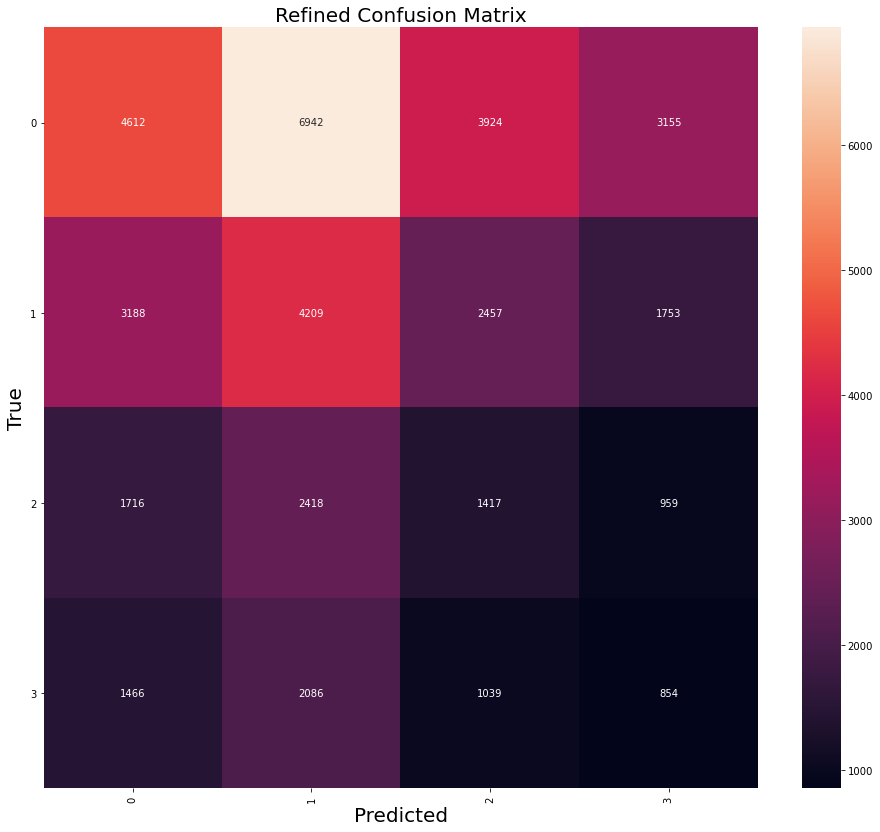

Logistic Reg Number of mislabeled points out of a total 42195 points : 31103
                    Mid         North        South         West  accuracy  \
precision      0.419960      0.268860     0.160349     0.127064  0.262875   
recall         0.247518      0.362626     0.217665     0.156841  0.262875   
f1-score       0.311464      0.308781     0.184661     0.140391  0.262875   
support    18633.000000  11607.000000  6510.000000  5445.000000  0.262875   

              macro avg  weighted avg  
precision      0.244058      0.300545  
recall         0.246163      0.262875  
f1-score       0.236324      0.269087  
support    42195.000000  42195.000000  


In [56]:
logit_condensed, logit_y_pred_condensed, logit_conf_condensed = logistic_reg(condensed_train, condensed_test)


In [57]:
british_pred = logit_condensed.predict(british_df)


condensed_pred = pd.DataFrame(british_pred, columns = ['pred_accent'])

condensed_pred['pred_tally'] = 1

print(condensed_pred['pred_accent'].value_counts())


condensed__sum = condensed_pred.groupby('pred_accent').sum()
condensed__sum['pred_percent'] = condensed__sum['pred_tally'] / condensed__sum['pred_tally'].sum() * 100.00

condensed__sum.head(10)


North    78709
Mid      47867
South    47229
West     32107
Name: pred_accent, dtype: int64


,pred_tally,pred_percent
pred_accent,,
Mid,47867,23.246338
North,78709,38.224581
South,47229,22.936497
West,32107,15.592583


In [58]:
consolidate_mas = {
    'North': 'East',
    'Mid': 'East',
    'South': 'East',
    'West': 'West',
}


condensed_train_two_regions, condensed_tes_two_regions = consolidate_regions(condensed_train, condensed_test, consolidate_mas)


condensed_train_two_regions.accent.value_counts()

East    19276
West     4087
Name: accent, dtype: int64

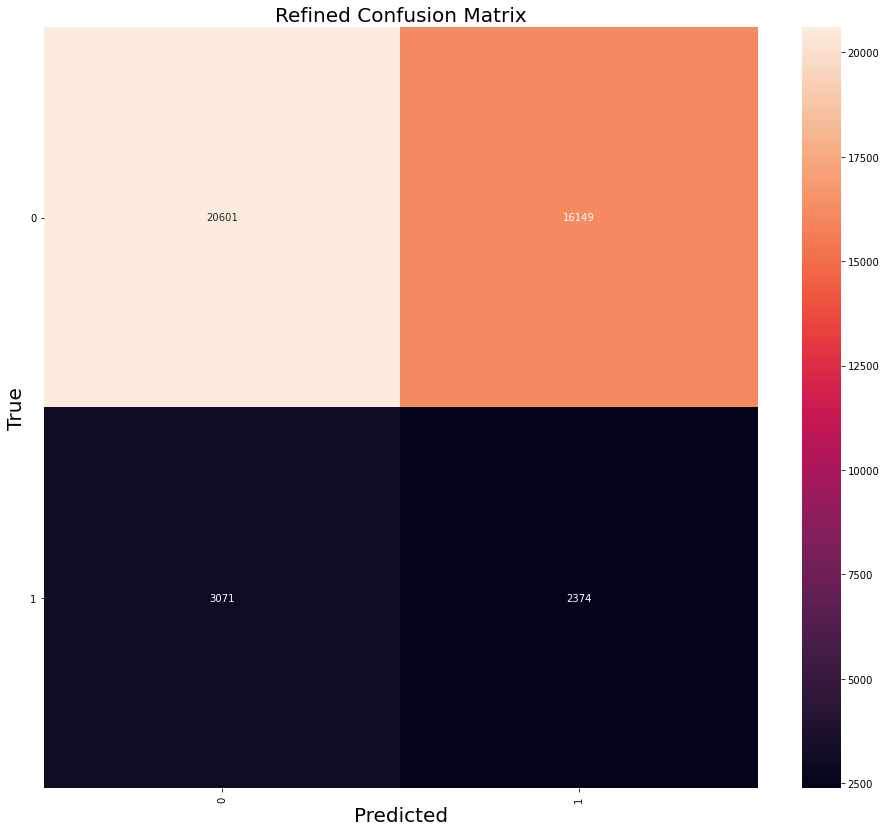

Logistic Reg Number of mislabeled points out of a total 42195 points : 19220
                   East         West  accuracy     macro avg  weighted avg
precision      0.870269     0.128165  0.544496      0.499217      0.774505
recall         0.560571     0.435996  0.544496      0.498284      0.544496
f1-score       0.681904     0.198097  0.544496      0.440001      0.619472
support    36750.000000  5445.000000  0.544496  42195.000000  42195.000000


In [59]:
logit_cm, logit_y_pred_cm, logit_conf_cm = logistic_reg(condensed_train_two_regions, condensed_tes_two_regions)


In [60]:
british_pred = logit_cm.predict(british_df)


cm_pred = pd.DataFrame(british_pred, columns = ['pred_accent'])

cm_pred['pred_tally'] = 1

print(cm_pred['pred_accent'].value_counts())


cm_pred__sum = cm_pred.groupby('pred_accent').sum()
cm_pred__sum['pred_percent'] = cm_pred__sum['pred_tally'] / cm_pred__sum['pred_tally'].sum() * 100.00

cm_pred__sum.head(10)

East    111992
West     93920
Name: pred_accent, dtype: int64


,pred_tally,pred_percent
pred_accent,,
East,111992,54.388282
West,93920,45.611718
